In [1]:
from histogram_functions import *
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import math
import cmath
from scipy.integrate import simpson, romb
from scipy.stats import iqr, norm, gaussian_kde
from scipy.special import erfc, wofz
from scipy.optimize import minimize
import pickle
import os
import warnings

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# parameters

mu = 0
nu = 1.2

alpha = 1 + 0.5 * 1j

n_precision = 1000
L_limit = find_suitable_L(mu, nu, alpha)
X_precision = np.linspace(-L_limit,L_limit,n_precision)
true_pdf = normalized_cat_state_pdf(mu, nu, alpha, X_precision)
kappa = 1

trial_times = 10
n = 500

hist_counts_per_time = []
W_Gaussian_per_time = []
MSE_Gaussian_per_time = []


for _ in tqdm(range(trial_times)):
    X_samples = samplings_with_noisy_pdf(true_pdf, X_precision, n, kappa)
    hist_counts, bin_edges = np.histogram(X_samples, bins=30, density=True)
    hist_counts_per_time.append(hist_counts)

    W_Gaussian = reconstruct_pdf_mle(X_samples, X_precision)
    MSE_Gaussian = simpson(y = (true_pdf - W_Gaussian)**2, x = X_precision)
    W_Gaussian_per_time.append(W_Gaussian)
    MSE_Gaussian_per_time.append(MSE_Gaussian)


avg_W_Gaussian = np.mean(W_Gaussian_per_time, axis=0)
std_W_Gaussian = np.std(W_Gaussian_per_time, axis=0)

avg_hist_counts = np.mean(hist_counts_per_time, axis=0)
std_hist_counts = np.std(hist_counts_per_time, axis=0)

avg_MSE_Gaussian = np.mean(MSE_Gaussian_per_time)
std_MSE_Gaussian = np.std(MSE_Gaussian_per_time)




100%|██████████| 10/10 [00:00<00:00, 14.39it/s]


Average Mean Squared Error of Gaussian Kernel:  0.005979012357982827 +- 0.0030434020283295294


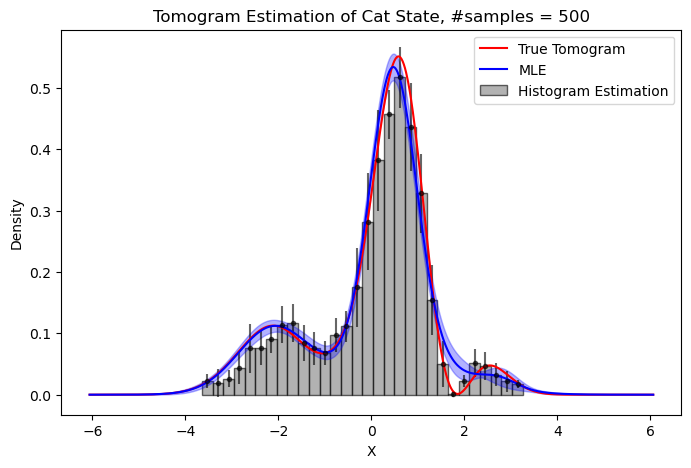

In [4]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


# Plot mean histogram with error bars
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, avg_hist_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, label="Histogram Estimation", color="gray", edgecolor="black")
plt.errorbar(bin_centers, avg_hist_counts, yerr=std_hist_counts, fmt='.', color="black", alpha = 0.6)

plt.plot(X_precision, true_pdf, color = 'red', label="True Tomogram")
plt.plot(X_precision, avg_W_Gaussian, color = 'blue', label="MLE")
plt.fill_between(X_precision, avg_W_Gaussian - std_W_Gaussian, avg_W_Gaussian + std_W_Gaussian, color = 'blue', alpha = 0.3)


plt.legend()
plt.xlabel("X")
plt.ylabel("Density")
plt.title("Tomogram Estimation of Cat State, #samples = {}".format(n))


print("Average Mean Squared Error of Gaussian Kernel: ", avg_MSE_Gaussian, "+-", std_MSE_Gaussian)

